# Lab Session 2: LLMs for Data Annotation and Classification

## Objectives

By the end of this lab, you will be able to:

1. Use LLMs for zero-shot and few-shot classification of press releases
2. Apply LLMs for data annotation tasks such as topic labeling and sentiment analysis
3. Generate summaries of press releases using LLMs
4. Analyze and interpret the results in the context of environmental communication

## Installation

Before we begin, let's install the necessary packages for this lab. Run the following cell to install the required libraries:


In [ ]:
%pip install nlp4ss

## Setup and Data Loading

We'll use the Sierra Club press release dataset from Lab Session 1. Let's start by loading the data and setting up our environment.


In [1]:
from hyfi import HyFI

if HyFI.is_colab():
    HyFI.mount_google_drive()
    project_root = "/content/drive/MyDrive/courses/nlp4ss"
else:
    project_root = "$HOME/workspace/courses/nlp4ss"

h = HyFI.initialize(
    project_name="nlp4ss",
    project_root=project_root,
    logging_level="WARNING",
    verbose=True,
)

raw_data_file = h.project.workspace_dir / "data/raw/articles.jsonl"
rdata = h.load_dataset("json", data_files=raw_data_file.as_posix())
df = rdata["train"].to_pandas()

# Display basic information about the dataset
print(df.info())
print("\nSample of the data:")
print(df.head())

/Users/yj.lee/.venvs/nlp4ss/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:hyfi.joblib.joblib:initialized batcher with <hyfi.joblib.batcher.batcher.Batcher object at 0x16f794680>


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6354 entries, 0 to 6353
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   title      6354 non-null   object
 1   timestamp  6354 non-null   object
 2   url        6354 non-null   object
 3   page_url   6354 non-null   object
 4   page       6354 non-null   int64 
 5   content    6354 non-null   object
 6   uuid       6354 non-null   object
dtypes: int64(1), object(6)
memory usage: 347.6+ KB
None

Sample of the data:
                                               title       timestamp  \
0  Sierra Club Urges Commerce Department to Hold ...  April 15, 2024   
1  Sierra Club Statement on BOEM Financial Assura...  April 15, 2024   
2  We Energies Files Third Rate Increase in Three...  April 15, 2024   
3  MEDIA ADVISORY: Oregon Regulators to Hear Conc...  April 12, 2024   
4  Advisory: Special Meeting for County Commissio...  April 12, 2024   

                                

## 1. Setting up LLM Access

We'll use the OpenAI GPT-4.5 model for this lab. Make sure you have the OpenAI Python library installed and your API key set up.


In [2]:
from openai import OpenAI
import os

# Set your OpenAI API key from the environment variable
api_key = os.getenv("OPENAI_API_KEY")
# or set it directly
api_key = "YOUR_API_KEY"

## Set the API key
client = OpenAI(api_key=api_key)


MODEL = "gpt-4o"


def get_completion(prompt, model=MODEL, temperature=0):
    completion = client.chat.completions.create(
        model=MODEL,
        messages=[
            {
                "role": "system",
                "content": "You are a helpful assistant that helps me with my research.",
            },
            {"role": "user", "content": prompt},
        ],
        temperature=temperature,
    )
    return completion.choices[0].message.content

## 2. Zero-shot Classification for Environmental Topics

Let's use zero-shot learning to classify the press releases into different environmental topics.


                                                content        zero_shot_topic
5775  April 5, 2017\n\n\nContact\n Emily Pomilio (20...       Renewable Energy
1840  October 28, 2021\n\n\nContact\nShiloh Hernande...  Environmental Justice
4272  December 6, 2018\n\n\nContact\nCourtney Bourgo...  Environmental Justice
80    Black households face disproportionately high ...  Environmental Justice
3133  February 24, 2020\n\n\nContact\nGabby Brown, g...           Conservation


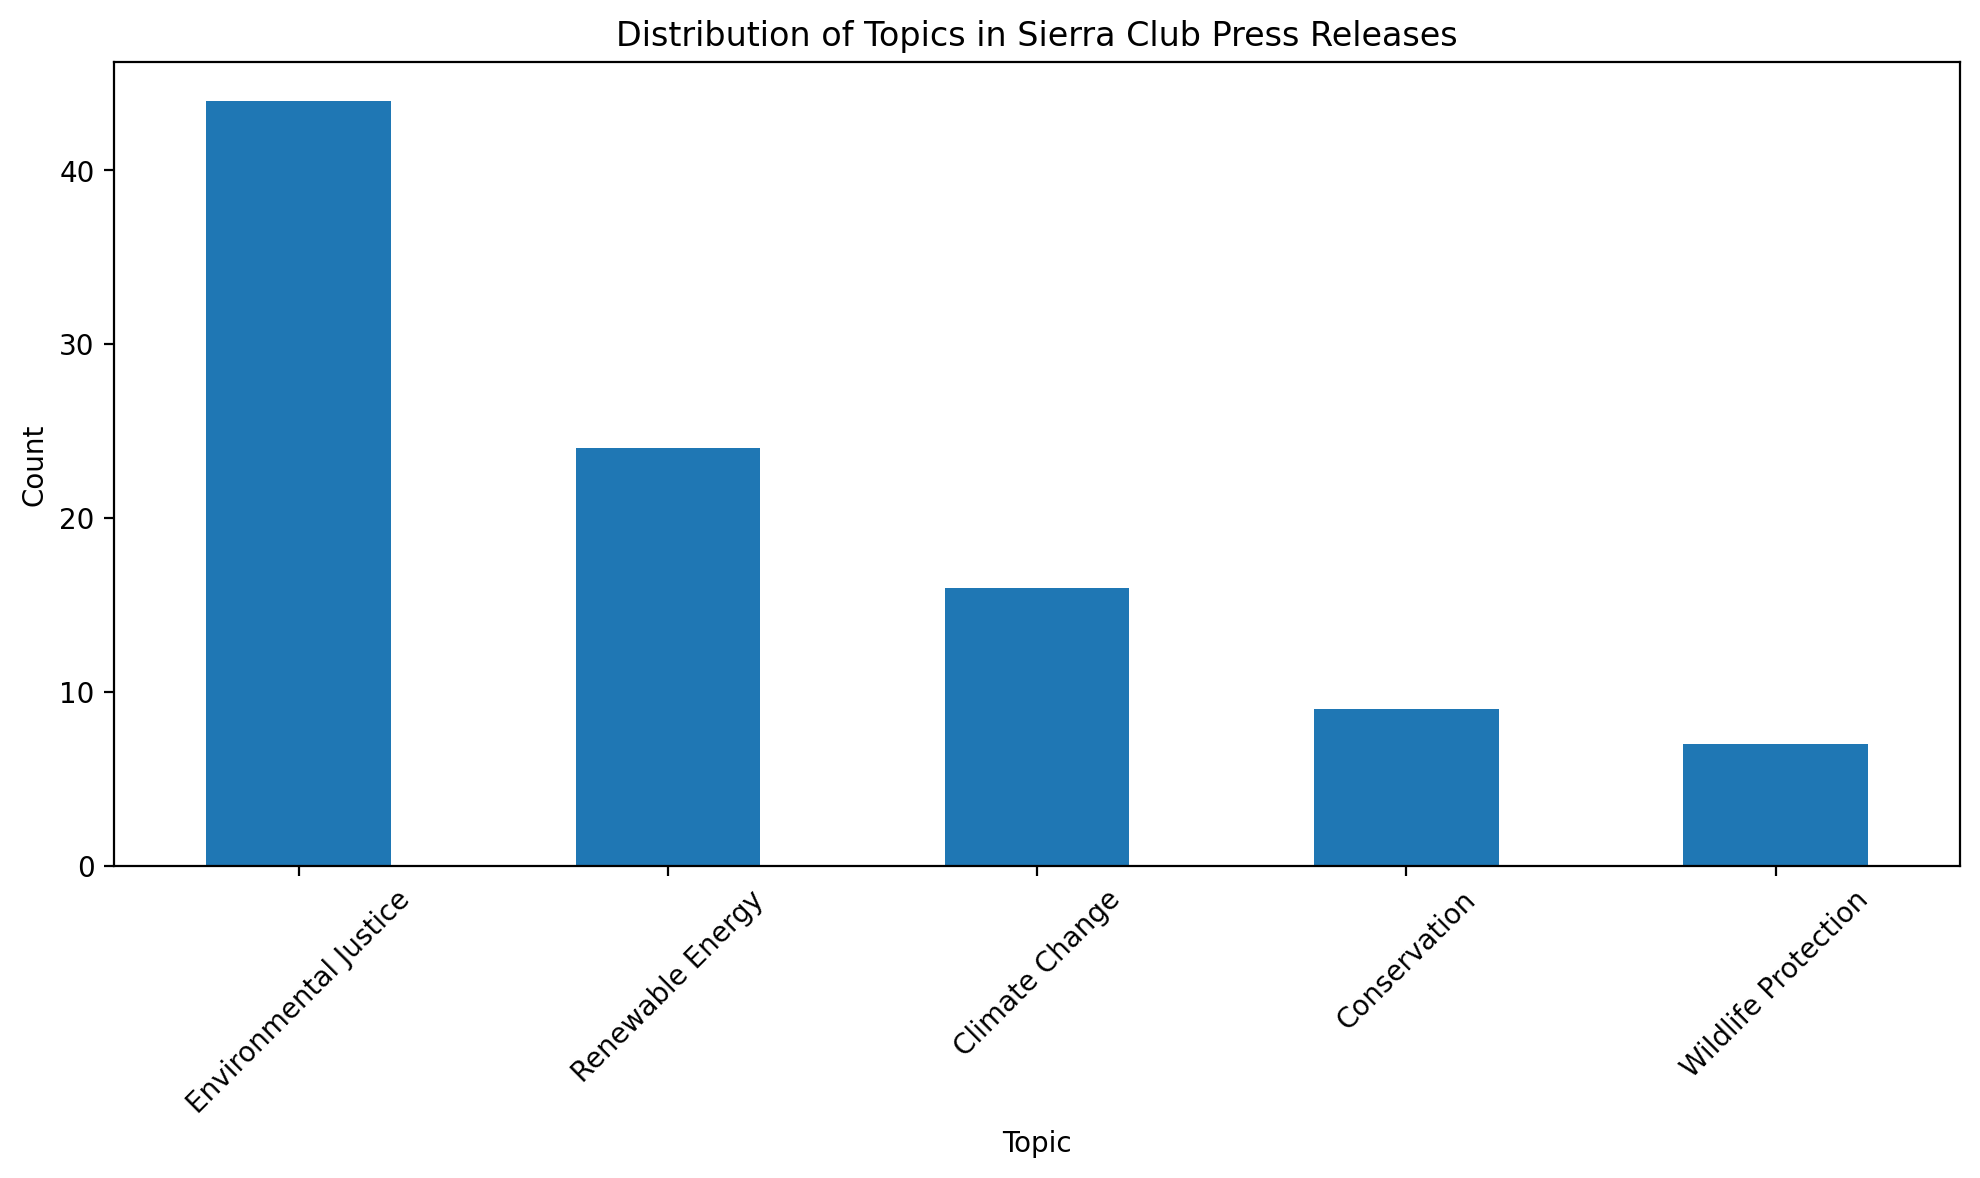

Saving classified topics to /Users/yj.lee/workspace/courses/nlp4ss/workspace/data/processed/sierra_club_topics.csv


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


def zero_shot_classification(text, categories):
    prompt = f"""
    Classify the following press release into one of these categories: {', '.join(categories)}.
    Only respond with the category name.

    Press Release: {text}

    Category:
    """
    return get_completion(prompt)


# Define categories
categories = [
    "Climate Change",
    "Conservation",
    "Renewable Energy",
    "Environmental Justice",
    "Wildlife Protection",
]

# Apply zero-shot classification to a sample of press releases
sample_size = min(100, len(df))
df_sample = df.sample(n=sample_size, random_state=42)
df_sample["zero_shot_topic"] = df_sample["content"].apply(
    lambda x: zero_shot_classification(x[:1000], categories)
)

# Display results
print(df_sample[["content", "zero_shot_topic"]].head())

# Visualize distribution of classified topics
plt.figure(figsize=(10, 6))
df_sample["zero_shot_topic"].value_counts().plot(kind="bar")
plt.title("Distribution of Topics in Sierra Club Press Releases")
plt.xlabel("Topic")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Save the classified topics to a CSV file
output_file = h.project.workspace_dir / "data/processed/sierra_club_topics.csv"
os.makedirs(output_file.parent, exist_ok=True)
print(f"Saving classified topics to {output_file}")
df_sample[["content", "zero_shot_topic"]].to_csv(output_file, index=False)

## 3. Few-shot Learning for Sentiment Analysis

Now, let's use few-shot learning to perform sentiment analysis on the press releases.


                                                content few_shot_sentiment
5775  April 5, 2017\n\n\nContact\n Emily Pomilio (20...           Positive
1840  October 28, 2021\n\n\nContact\nShiloh Hernande...           Positive
4272  December 6, 2018\n\n\nContact\nCourtney Bourgo...           Negative
80    Black households face disproportionately high ...           Negative
3133  February 24, 2020\n\n\nContact\nGabby Brown, g...            Neutral


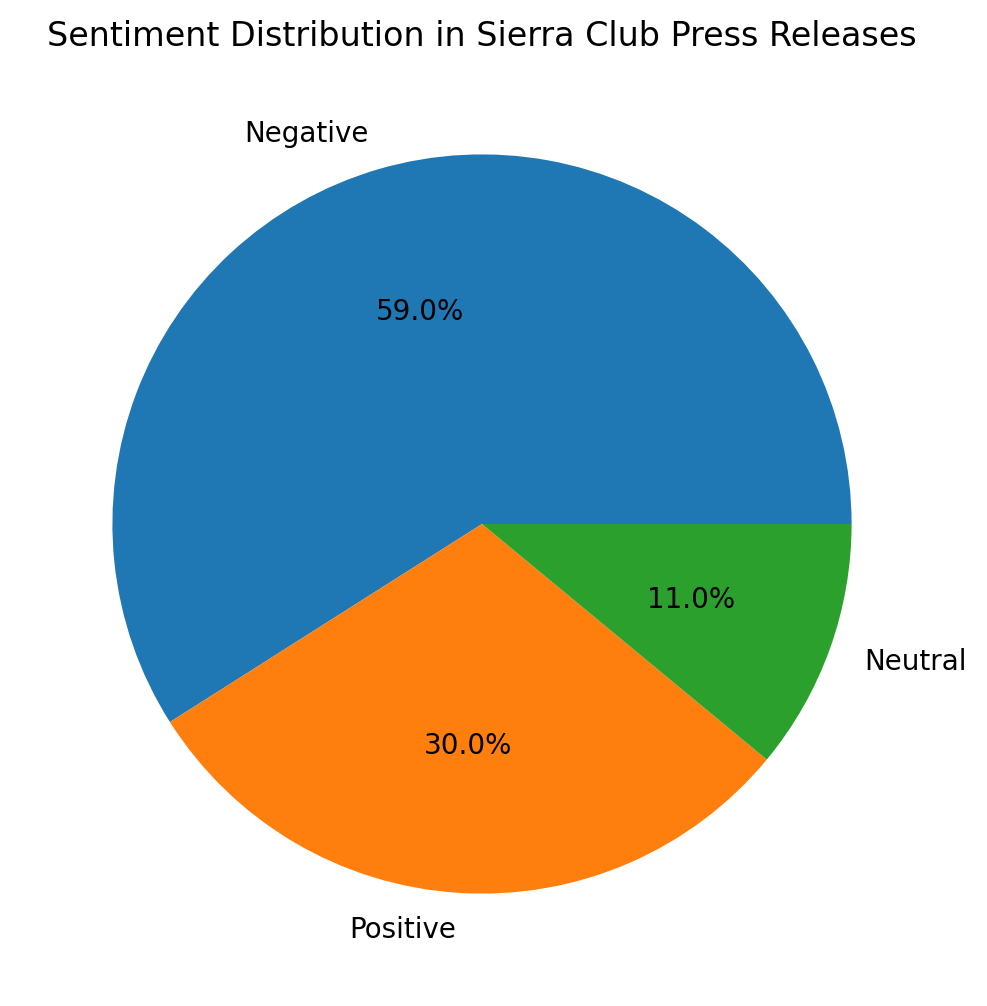

Saving sentiment analysis results to /Users/yj.lee/workspace/courses/nlp4ss/workspace/data/processed/sierra_club_sentiment.csv


In [4]:
def few_shot_sentiment_analysis(text):
    prompt = f"""
    Analyze the sentiment of the following press releases. Classify each as positive, negative, or neutral.
    Just give the sentiment of the press release without any additional information.
    Also, don't start the response with "The sentiment is" or "Sentiment: ".

    Press Release: "We are thrilled to announce a major victory in our fight against climate change. The new legislation will significantly reduce carbon emissions."
    Sentiment: Positive

    Press Release: "The recent oil spill has caused devastating damage to local ecosystems. We demand immediate action to prevent such disasters in the future."
    Sentiment: Negative

    Press Release: "The Sierra Club will be hosting its annual meeting next month to discuss ongoing projects and future initiatives."
    Sentiment: Neutral

    Press Release: {text[:1000]}
    Sentiment:
    """
    return get_completion(prompt)


# Apply few-shot sentiment analysis to the sample
df_sample["few_shot_sentiment"] = df_sample["content"].apply(
    few_shot_sentiment_analysis
)

# Display results
print(df_sample[["content", "few_shot_sentiment"]].head())

# Visualize sentiment distribution
plt.figure(figsize=(8, 6))
df_sample["few_shot_sentiment"].value_counts().plot(kind="pie", autopct="%1.1f%%")
plt.title("Sentiment Distribution in Sierra Club Press Releases")
plt.ylabel("")
plt.show()

# Save the sentiment analysis results to a CSV file
output_file = h.project.workspace_dir / "data/processed/sierra_club_sentiment.csv"
print(f"Saving sentiment analysis results to {output_file}")
df_sample[["content", "few_shot_sentiment"]].to_csv(output_file, index=False)

## 4. LLM-based Data Annotation: Key Environmental Issues

Let's use the LLM to annotate our press releases with key environmental issues mentioned.


                                                content  \
5775  April 5, 2017\n\n\nContact\n Emily Pomilio (20...   
1840  October 28, 2021\n\n\nContact\nShiloh Hernande...   
4272  December 6, 2018\n\n\nContact\nCourtney Bourgo...   
80    Black households face disproportionately high ...   
3133  February 24, 2020\n\n\nContact\nGabby Brown, g...   

                                             key_issues  
5775  energy efficiency; electricity usage reduction...  
1840         water quality; contamination; strip mining  
4272  habitat destruction; environmental damage; flo...  
80    Energy burdens; Historic discrimination; Disin...  
3133  oil and gas drilling in the Arctic; thermal co...  


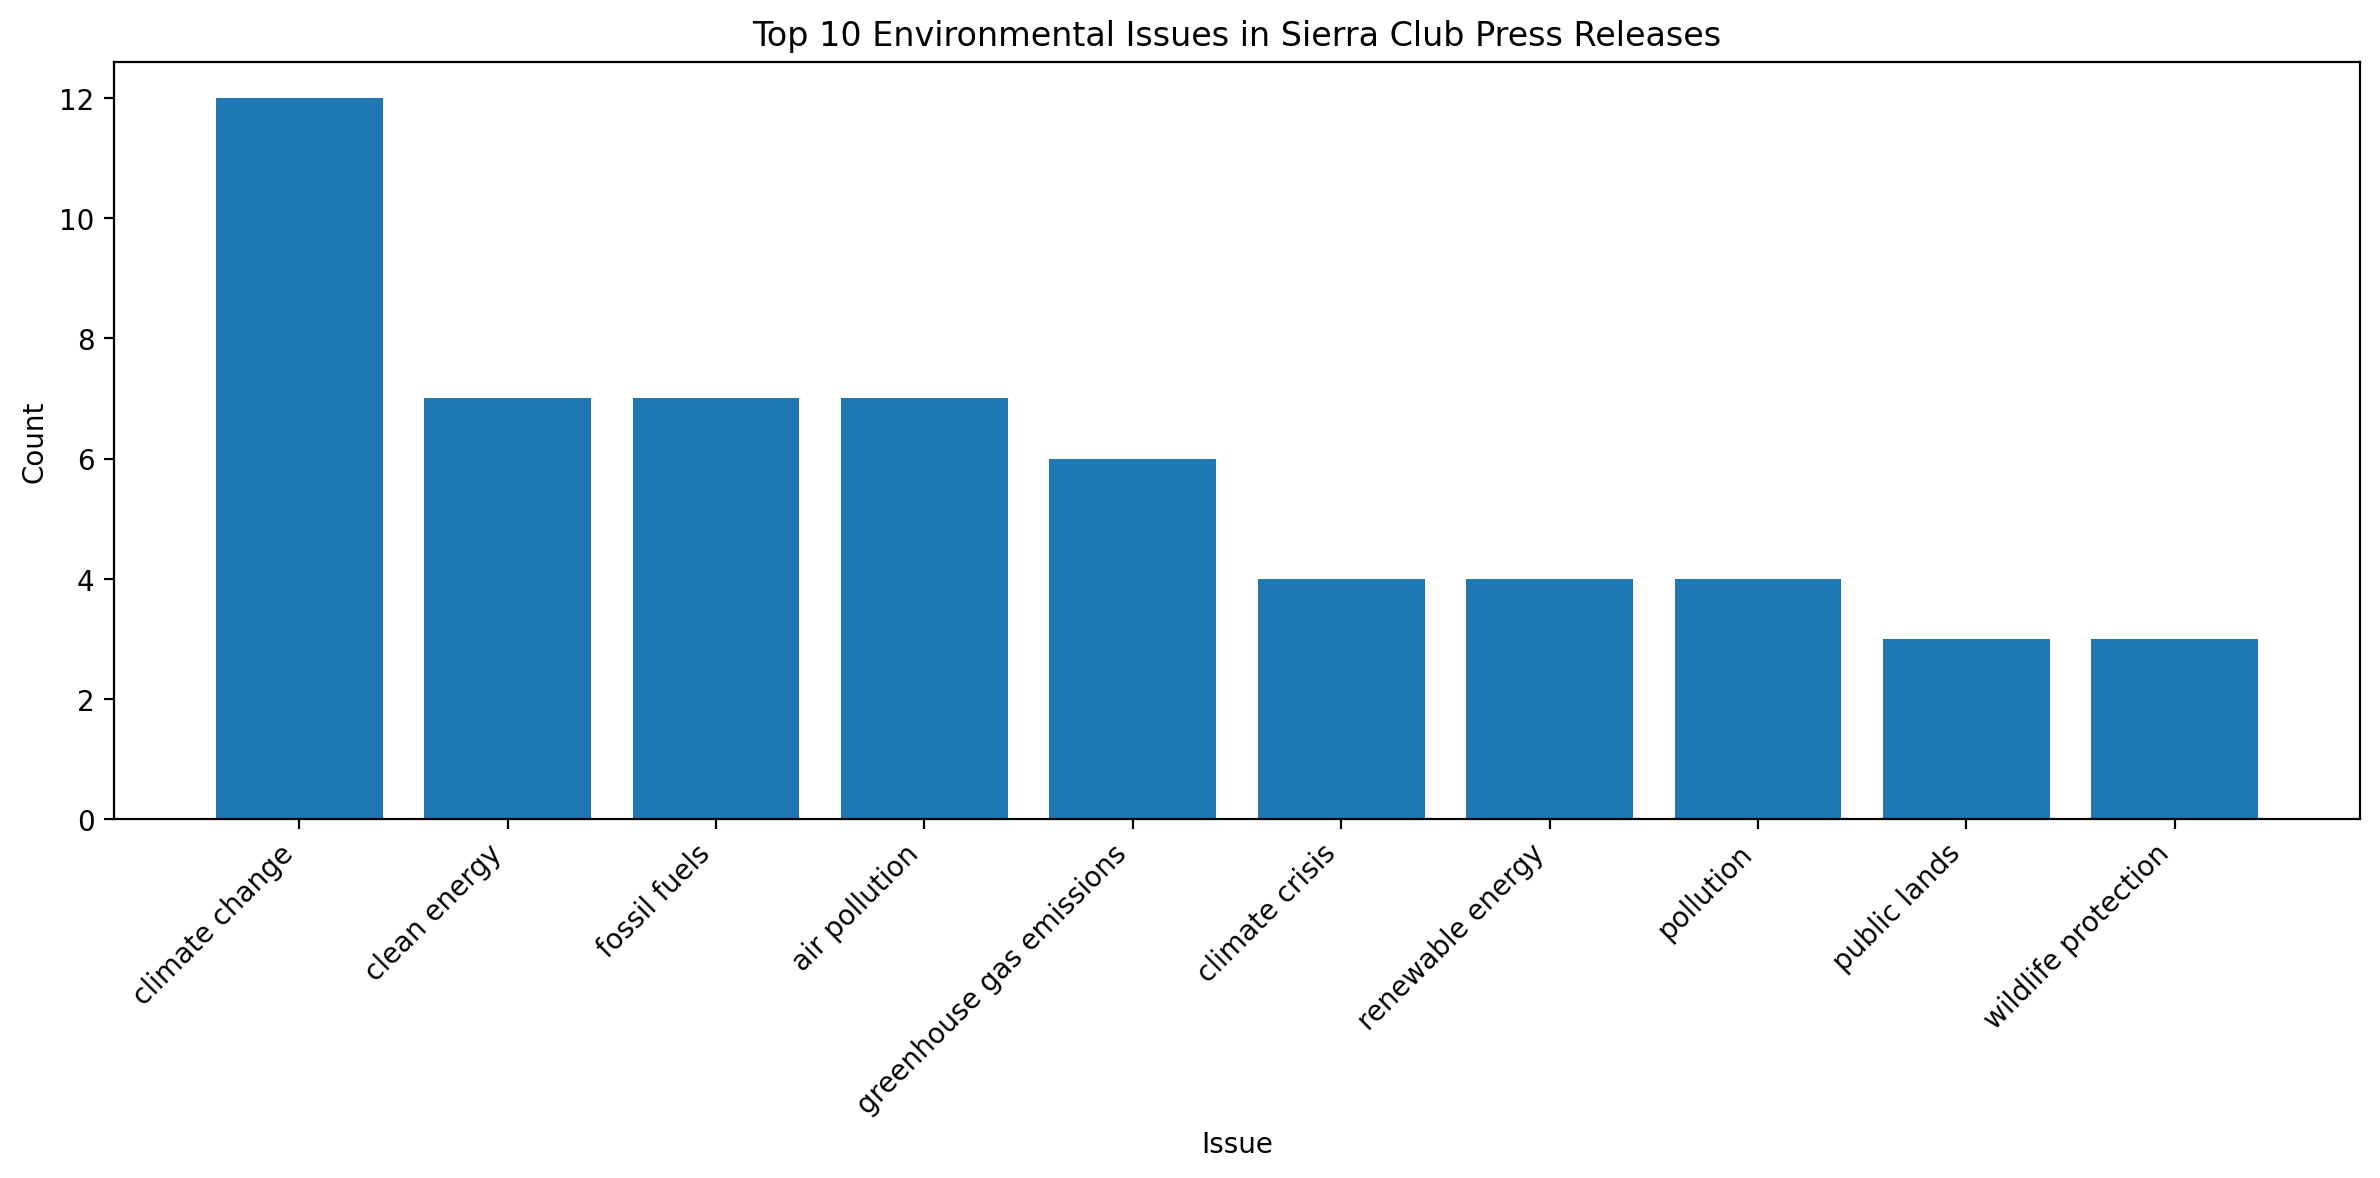

Saving extracted key issues to /Users/yj.lee/workspace/courses/nlp4ss/workspace/data/processed/sierra_club_key_issues.csv


In [5]:
def extract_key_issues(text):
    prompt = f"""
    Extract the top 3 key environmental issues mentioned in the following press release. 
    Respond only with the issues, separated by semicolons.
    Use only nouns or noun phrases as the key issues.
    Key issues should be specific to environmental concerns.

    Press Release: {text[:1500]}

    Key Issues:
    """
    return get_completion(prompt)


# Apply key issue extraction to the sample
df_sample["key_issues"] = df_sample["content"].apply(extract_key_issues)

# Display results
print(df_sample[["content", "key_issues"]].head())

# Analyze most common issues
from collections import Counter

all_issues = [
    issue.strip() for issues in df_sample["key_issues"] for issue in issues.split(";")
]
issue_counts = Counter(all_issues)

plt.figure(figsize=(12, 6))
plt.bar(*zip(*issue_counts.most_common(10)))
plt.title("Top 10 Environmental Issues in Sierra Club Press Releases")
plt.xlabel("Issue")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Save the extracted key issues to a CSV file
output_file = h.project.workspace_dir / "data/processed/sierra_club_key_issues.csv"
print(f"Saving extracted key issues to {output_file}")
df_sample[["content", "key_issues"]].to_csv(output_file, index=False)

## 5. Generating Summaries with LLMs

Let's use the LLM to generate concise summaries of the press releases.


In [6]:
def generate_summary(text, max_length=1000):
    prompt = f"""
    Summarize the following Sierra Club press release in 2-3 sentences:

    {text[:max_length]}

    Summary:
    """
    return get_completion(prompt)


# Generate summaries for the sample
df_sample["summary"] = df_sample["content"].apply(generate_summary)

# Display results
print(df_sample[["content", "summary"]].head())

# Save the generated summaries to a CSV file
output_file = h.project.workspace_dir / "data/processed/sierra_club_summaries.csv"
print(f"Saving generated summaries to {output_file}")
df_sample[["content", "summary"]].to_csv(output_file, index=False)

                                                content  \
5775  April 5, 2017\n\n\nContact\n Emily Pomilio (20...   
1840  October 28, 2021\n\n\nContact\nShiloh Hernande...   
4272  December 6, 2018\n\n\nContact\nCourtney Bourgo...   
80    Black households face disproportionately high ...   
3133  February 24, 2020\n\n\nContact\nGabby Brown, g...   

                                                summary  
5775  The Maryland General Assembly has enacted upda...  
1840  A Montana district court judge ruled that the ...  
4272  More than 500 diverse organizations and 2,845 ...  
80    A new report by Dr. Marilyn A. Brown of Georgi...  
3133  JPMorgan Chase has announced a new energy poli...  
Saving generated summaries to /Users/yj.lee/workspace/courses/nlp4ss/workspace/data/processed/sierra_club_summaries.csv


## 6. Analysis and Interpretation

Now that we've applied various LLM-based techniques to our Sierra Club press release dataset, let's analyze and interpret the results in the context of environmental communication.

1. Examine the distribution of topics in the press releases. What does this tell us about the Sierra Club's focus areas and communication strategies?

2. Analyze the sentiment distribution across different topics. Are there any notable patterns in how the Sierra Club frames different environmental issues?

3. Look at the key environmental issues extracted. How do these align with broader environmental discourse and policy debates?

4. Compare the LLM-generated summaries with the original press releases. How effectively do they capture the main points?

5. Discuss how these LLM-based analyses could be used to study environmental communication strategies and public engagement with environmental issues.

## 7. Exercise

For your exercise, please complete the following tasks:

1. Implement a few-shot learning approach to classify press releases by their primary call to action (e.g., public awareness, policy change, community action, donation request).

2. Use the LLM to extract quotes from the press releases, along with the speaker's name and affiliation.

3. Create a visualization that shows how the topics and sentiments in Sierra Club press releases have changed over time (use the 'timestamp' column).

4. Write a brief (300-350 words) analysis of your findings, discussing the potential of LLMs for analyzing environmental communication and the implications for social science research on environmental advocacy.

Submit your code, visualizations, and written analysis.

## Ethical Considerations

As you work through this lab, consider the following ethical questions:

1. What are the potential biases in using LLMs to analyze environmental communication?

2. How might the use of AI-generated summaries or classifications influence public understanding of environmental issues?

3. What responsibilities do researchers have when using LLM-based analyses in studies of environmental advocacy?

4. How can we ensure that the use of LLMs in analyzing press releases doesn't oversimplify complex environmental issues?
